In [ ]:
#----------unzip all images-----------

ZIP_PATH = '/content/drive/MyDrive/data/classes_original_full/classes_original.zip'

import zipfile
with zipfile.ZipFile(ZIP_PATH,"r") as zip_ref:
    zip_ref.extractall("./")

In [ ]:
#pip install tensorflow-gpu==1.15.0

In [ ]:

!pip install keras
!pip install tensorflow


In [ ]:
!pip install split-folders

In [ ]:
# split dataset into train, test and validation datasets
import os
import splitfolders
import numpy as np
import tqdm
from pathlib import Path

PATH = '/content/classes/'

splitfolders.ratio(PATH, output="train_data", seed=1332, ratio=(0.7,0.2,0.1))

Copying files: 10217 files [00:02, 4674.80 files/s]


In [ ]:
# Print all breeds' name

from glob import glob
PATH = 'train_data/'
dog_names = [item[17:] for item in sorted(glob(PATH + "train/*"))]
print(dog_names)

['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'iris

In [ ]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
from tensorflow.keras.utils import load_img, img_to_array
from glob import glob
import numpy as np
import tensorflow as tf

PATH = 'train_data/'

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 120)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset(PATH + 'train')
valid_files, valid_targets = load_dataset(PATH + 'val')
test_files, test_targets = load_dataset(PATH + 'test')



#----------Dog detector on image-----------

from keras.applications.resnet import ResNet50
# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

from keras.applications.resnet import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151))


#--------------- image to tensor---------------

from keras.preprocessing import image
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)


train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255


from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True, # randomly flip images horizontally
    shear_range=0.2,
    zoom_range=0.2,) 

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
    width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True, # randomly flip images horizontally
    shear_range=0.2,
    zoom_range=0.2,) 

# datagen_valid = ImageDataGenerator(
#         width_shift_range=0.1,  # randomly shift images horizontally (10% of total width)
#         height_shift_range=0.1,  # randomly shift images vertically (10% of total height)
#         rotation_range=40,
#         zoom_range = 0.1,
#         rescale=1./255)

# fit augmented image generator on data
datagen_train.fit(train_tensors)
datagen_valid.fit(valid_tensors)




In [ ]:

###-------------------- Train the model.--------------------

input_shape =(224,224,3)
# folderek száma legyen
NUM_CLASSES = 120


from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.applications.xception import Xception

base_model = Xception(weights='imagenet',
                      input_shape =(224,224,3),
                      include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
# let's add a fully-connected layer
# x = Dense(1024, activation='relu')(x)
# and a logistic layer -- 
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False


from keras import optimizers
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras import Model


optimizer = optimizers.RMSprop(learning_rate=0.001, rho=0.9, epsilon=None, decay=0.0)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

earlystopping = EarlyStopping(monitor ="val_loss", 
                              mode ="min", patience = 5, 
                              restore_best_weights = True)

batch_size = 32
epochs = 100

xception = Model(inputs=base_model.input, outputs=predictions)
# this is the model we will train
xception.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

xception.fit(
                    datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),
                    # // batch size kivéve
                    steps_per_epoch = train_tensors.shape[0],
                    epochs=epochs, 
                    batch_size = batch_size,
                    callbacks=[earlystopping, learning_rate_reduction],
                    validation_data = datagen_valid.flow(valid_tensors, valid_targets, batch_size=batch_size),
                    validation_steps = valid_tensors.shape[0])

xception.save('/content/drive/MyDrive/data/my_model_120_20.h5')


# # report test accuracy

# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(xception.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# print(np.argmax(xception.predict(np.expand_dims(test_tensors[0], axis=0))))
# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


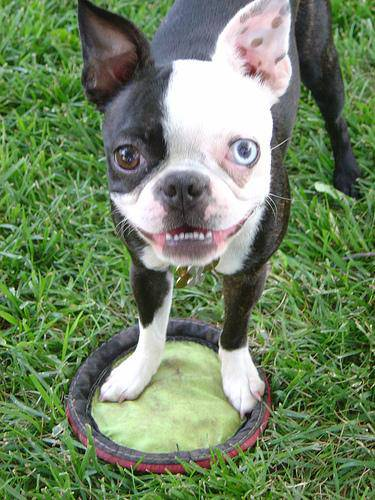

1/1 [==============================] - 0s 22ms/step
This is predicted to be a dog, and its breed is: 


1/1 [==============================] - 1s 717ms/step
boston_bull


In [ ]:
# -----------------Breed predict---------------------
from tensorflow import keras
xception = keras.models.load_model('/content/drive/MyDrive/data/my_model_120_20.h5')
def predict_breed(img_path):
    

    image_as_tensor = path_to_tensor(img_path).astype('float32')/255
    pred_vector = xception.predict(image_as_tensor)

    return dog_names[np.argmax(pred_vector)]

from IPython.core.display import Image, display

def breed_algorithm(img_path):
    display(Image(img_path, width=200, height=200))
    
    if dog_detector(img_path) == 1:
        print("This is predicted to be a dog, and its breed is: ")
        return predict_breed(img_path)
    else:
        return print("It wasn't possible to identify a dog in the image. Please try again.")

print(breed_algorithm("/content/train_data/test/boston_bull/010d65bd29d246aea53d9849da142ccf.jpg"))